<a href="https://colab.research.google.com/github/Done-Yang/CSS_Layout_learning/blob/main/starterproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Frame the problems


- in califonia
- To prediction of a district's median housing price
- Housing price are currently extimate manualy by expert

#### Sytem sesigning
- train as supervised kind
- regression task
- train as bath learning

### Get the Data

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

#### Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

#### Take a Quick Look at the Data Structure

In [2]:
## list 5 line on the top head()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
## quick description of the data info()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
## categories the duplicate row value_counts()
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
## summary of the numerical attributes describe()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The following cell is not shown either in the book. It creates the `images/end_to_end_project` folder (if it doesn't already exist), and it defines the `save_fig()` function which is used through this notebook to save the figures in high-res for the book.

In [6]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

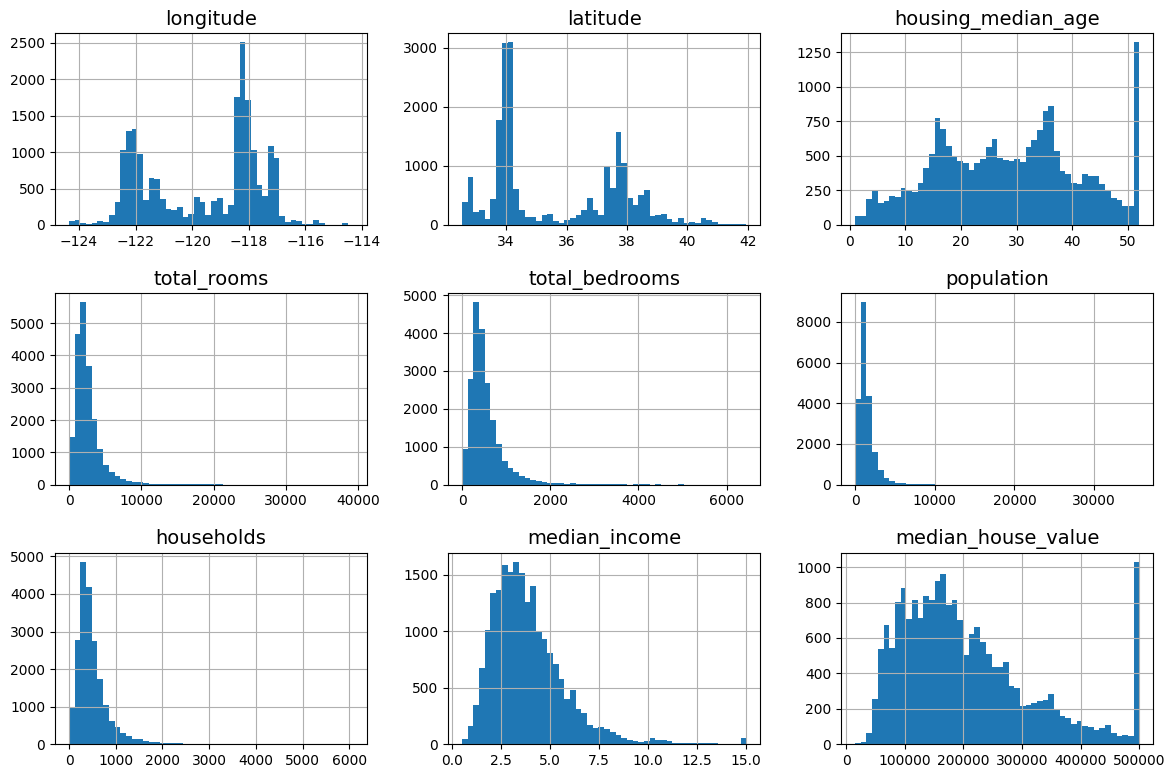

In [7]:
## to plotting the histogram for each nnumerical attribute
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

#### Create test set


In [8]:
from zlib import crc32
import numpy as np

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
## indentifier the column by adding index

housing_with_id = housing.reset_index()  ## add an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print("--------train set----------")
print(train_set)

print("--------test set----------")
print(test_set)

--------train set----------
       index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
6          6    -122.25     37.84                52.0       2535.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1  

In [10]:
## To stable feature to build a unique identifier

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print("--------train set----------")
print(train_set)

print("--------test set----------")
print(test_set)

--------train set----------
       index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
2          2    -122.24     37.85                52.0       1467.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1  

In [11]:
## Scikit-learn few function to split dataset into multiple subset in various ways

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
test_set["total_bedrooms"].isnull().sum()

44

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the binomial distribution. The cdf() method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [13]:
##  simulations with binom() of scipy

from scipy.stats import binom

sample_size = 1000
ration_female = 0.511
proba_too_small = binom(sample_size, ration_female).cdf(485- 1)
proba_too_larg = 1 - binom(sample_size, ration_female).cdf(535)

print(proba_too_small + proba_too_larg)

0.10736798530929942


In [14]:
## simulations over maths

import numpy as np

sample = (np.random.rand(100_000, sample_size) < ration_female).sum(axis=1)
((sample < 485) | (sample > 535)).mean()

0.10663

In [15]:
## To create an income category attribute with 5 categories

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

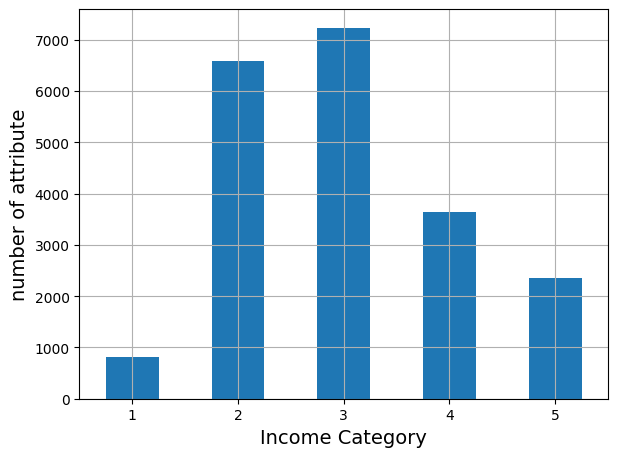

In [16]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
save_fig("income_cat_bar_plot")
plt.xlabel("Income Category")
plt.ylabel("number of attribute")
save_fig("housing_icome_cat_bar_plot")

In [17]:
## To be prcise sould split the training and test indices

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [19]:
 ## measure the income category proportion in the full dataset
import pandas as pd

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [20]:
## Back everything of the data to the original state

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Discover and visulize the Data to Gain Insights

In [21]:
## Make a copy the original for revert to it afterward
housing = strat_train_set.copy()

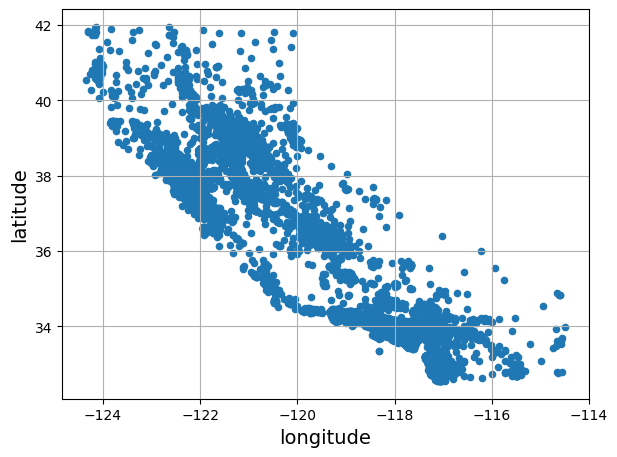

In [22]:
## Visualize geographical data

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")

plt.show()

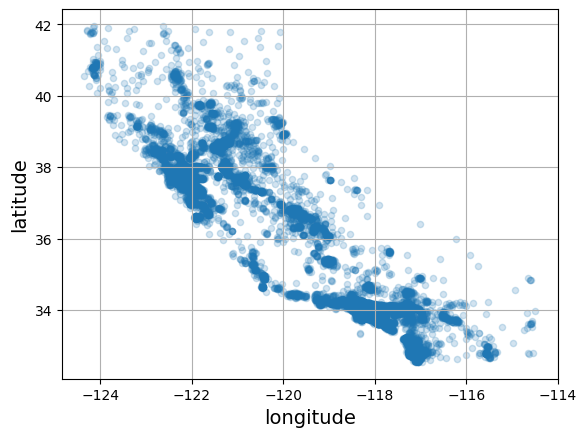

In [23]:
## To make it much esier to visulize the place (alpha=0.2)

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

plt.show()

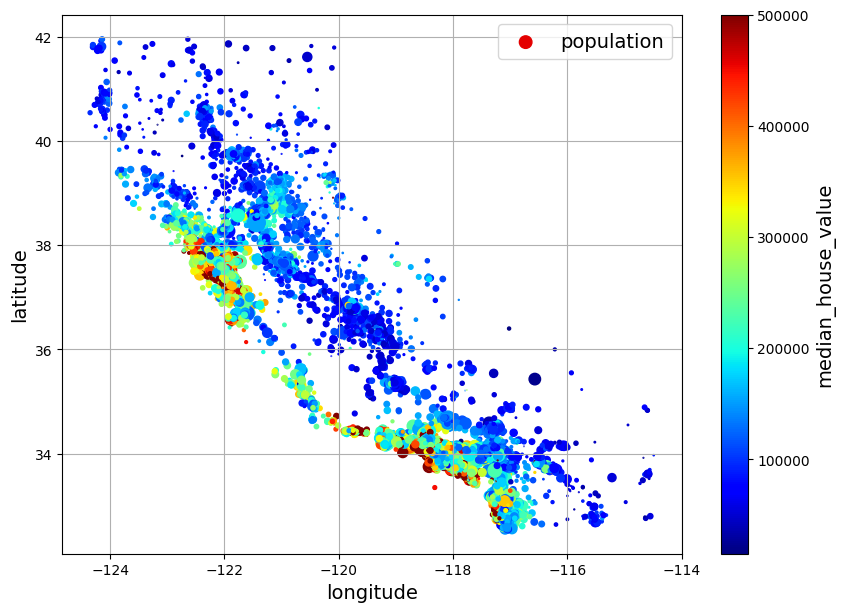

In [24]:
## Housing price as the color

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100,
             label="population", c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

plt.show()

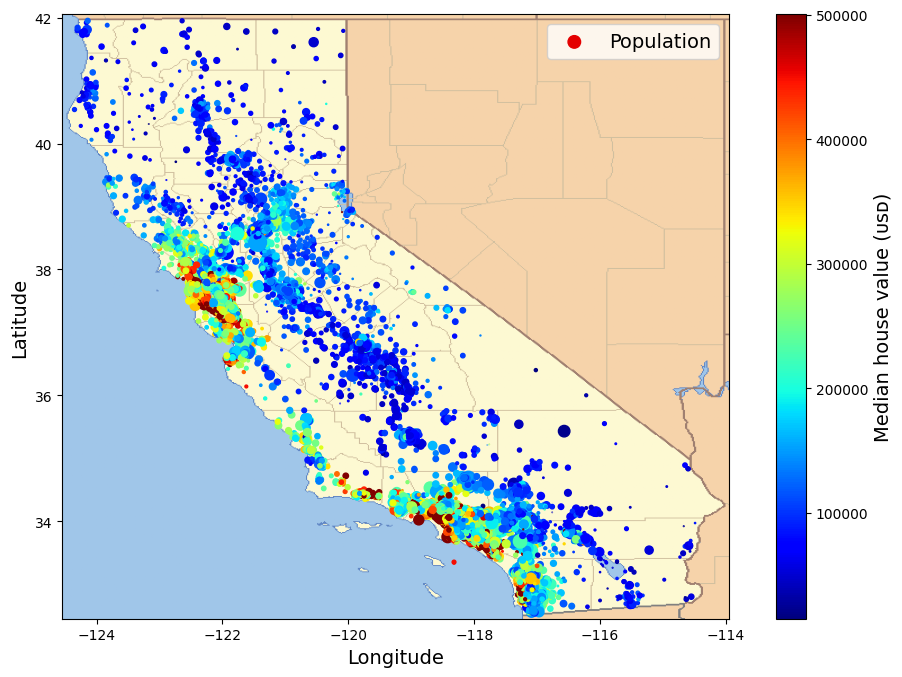

In [25]:
## nicer label names and no grid

# Download the colifonia image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

In [26]:
## To look for correlation or compute the standard correlation coefficient (Pearson's r) between every pair of attribute  corr()

corr_matrix = housing.corr(numeric_only=True)

In [27]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


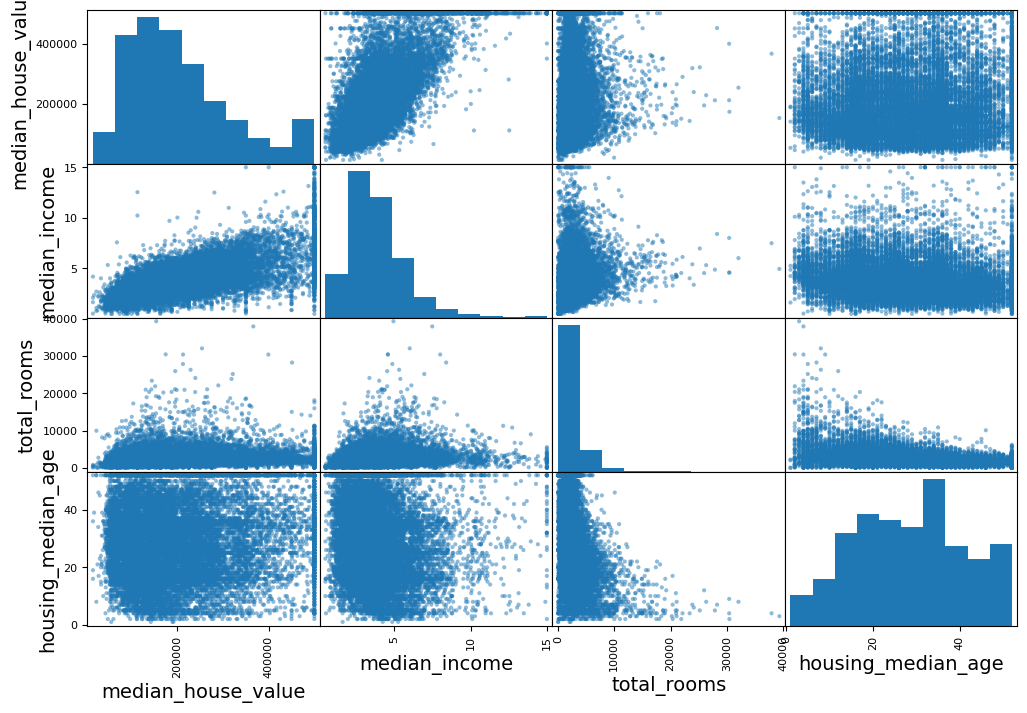

In [29]:
## To plot the every numerical attributes against every other numerical attribute

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

plt.show()

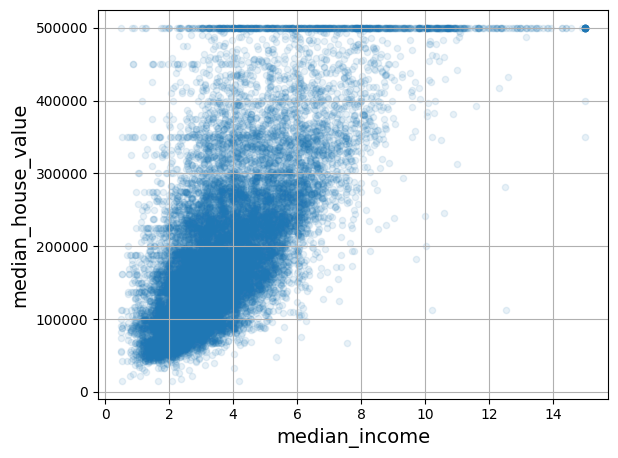

In [30]:
## To zoom in on the scatterplot
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

In [31]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


Experimenting with Attribute Combinations

In [32]:
## Create new attribute to the housing

housing['rooms_per_house11'] = housing['total_rooms'] / housing['households']
housing['badrooms_ration'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_hous'] = housing['population'] / housing['households']




In [33]:
housing


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house11,badrooms_ration,people_per_hous
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN,4.277247,0.266875,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND,5.535714,0.201019,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN,5.157895,0.197704,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN,4.511933,0.230891,2.058473


In [34]:
## Look at the correlation

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house11,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_hous,-0.038224
longitude,-0.050859


### Prepare the Data for Machine Learning

In [35]:
## Create a copy of the data that does not affect strat_train_set

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

print(housing )

print("--------housing_labels----------")
print(housing_labels)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41     37.66                44.0        431.0           195.0   

       population  households  median_income ocean_

#### Data Cleaning


For each option, we'll create a copy of housing and work on that copy to avoid breaking housing. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [36]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [37]:
## To accomplish the attribute has missing values

housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [38]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [39]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

<ipython-input-39-b6dffbe9d505>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [40]:
## To replace the median to the missing value

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [41]:
## To create a copy of the data with the only numerical attribute

housing_num = housing.select_dtypes(include=[np.number])

In [42]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [43]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [44]:
## Check that this is the same as manually computing the median of each attribute

housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [45]:
## Transform the training set

X = imputer.transform(housing_num)

In [46]:
X


array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

In [47]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [48]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [49]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [50]:
imputer.strategy

'median'

In [51]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


In [52]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


Now let's drop some outliers:

In [53]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [54]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [55]:
## If want to drop the outliers, you would like to run this code

#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

#### Handling Text and Categorical Attributes

In [56]:
## Preprocess the categorical input feature. ocean_proximity (the attribute still the text)

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(18)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [57]:
## To convert the categories from text to numbers OrdinalEncoder()

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:20]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [4.],
       [0.],
       [1.],
       [3.],
       [1.],
       [0.]])

In [58]:
## To get the list of categories categories_instance

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
## To convert categories value into one-hot vectors

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)  # with this the output is SciPy spare matrix instead of Numpy array
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [60]:
## To convert to (dense) NumPy Array

housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [61]:
## Alternatively, set the sparse_output = False whe creating the OneHOtEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [62]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [63]:
## Use pandas function to convert each cateforical feature into one-hot get_dummies()

df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [64]:
## Make the transform the same df_test

cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [65]:
## When fit any Scikit-Learn estimators using a DetaFrame, it will stores the column feature_names_in attribute, it has the same colo=umn names

cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [66]:
## Transform also provide a get_feature_nbames_out() that can use to build a DataFrame around the transformer's output

cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [67]:
## The get_dummies() still happily generate a column for it when it containing the a=unknown cataegory

df_test_unkown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unkown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [68]:
## the smarter OneHotEncoder, it will detect the unknown cataegory and raise exception (set the handle_unknown hyperparameter to "ignore" then the unknown category will represent with zeros)

cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unkown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

#### Feature Scaling

In [69]:
## Min-Max scaling (normalization) performed by: substracting the min value and deveding by the defferent between the min and the max
# using Min-Max scaling in Scikit-Learn MinMaxScaler()

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) # "feature_range" let you change the range (e.g. natrual network work best with zero-mean inputs, so a range of -1 to 1 is preferable)
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [70]:
housing_num_min_max_scaled[:5]

array([[-0.60851927,  0.11702128,  1.        , -0.83117147, -0.64116605,
        -0.80701754, -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, -0.90014752, -0.88629409,
        -0.91866029, -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, -0.94501246, -0.93042358,
        -0.93141946, -0.92458466, -0.73336919],
       [ 0.46855984, -0.74468085, -0.37254902, -0.78778168, -0.7262039 ,
        -0.77401546, -0.70916558, -0.75698266],
       [ 0.25760649, -0.74042553,  0.37254902, -0.77801516, -0.6102432 ,
        -0.76579561, -0.56281501, -0.58217128]])

In [71]:
## Standardization: substracts the mean value, then devides the result by the standard deviation. (Standardization is much less affected by outlier)
# using standardization in Scikit-Learn StandardScaler()

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)


When the feature's distribution has a heavy tail (i.e., when value far from the mean are not exponentially)

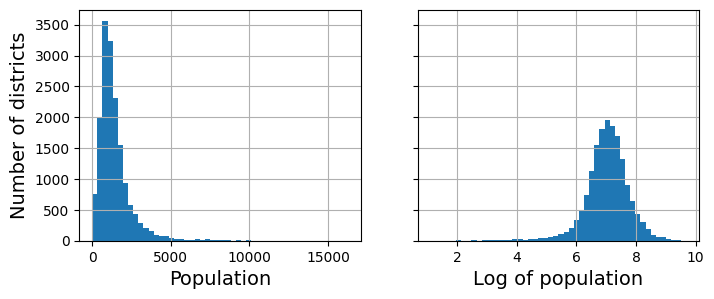

In [72]:
## To deal with the heavy tail
# Transforming a feature to make it close to a Gaussian distribution

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)    #population
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)  #log of population
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

What if we replace each value wiht its percentile?

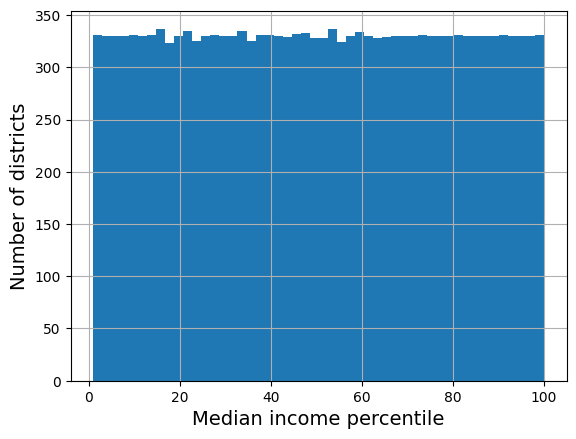

In [73]:
##  Show that we get uniform districbution

percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).



In [74]:
## Create new gaussian feature measuring the similarity between the housing median age and the measure decays using Radial Basis function rbf_kernel()

from sklearn.metrics.pairwise import rbf_kernel

age_similar_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1) # gamma (γ): determines how quickly the similarity measure decays



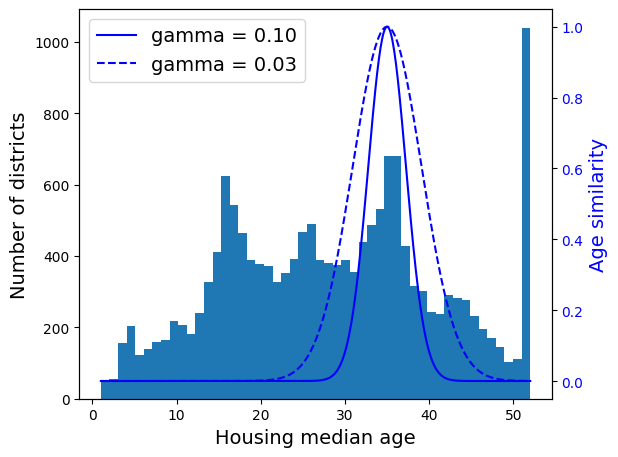

In [75]:
## To shows the measuring the similarity between the housing median age and 35

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [76]:
## To train the model on the single raw input feature (median icome)

from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predistions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predistions)


In [77]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [78]:
## the simpler option is to use the TransformedTargetRegressor

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [79]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

#### Custom Transformers

In [80]:
## To create a log-transformer and apply it to the population feature

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) # inverse_func: to specify an invers transform function
log_pop = log_transformer.transform(housing[["population"]])

In [81]:
## Create a transformer that compute the same gaussian RBF similarity

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args = dict(Y=[[35.]], gamma=0.1))

age_similar_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [82]:
age_similar_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [83]:
## To add a featuere that will measure the geographic similarity between each district

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))

sf_similar = sf_transformer.transform(housing[["latitude", "longitude"]])

In [84]:
sf_similar

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [85]:
## The customer feature to combine features

ration_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ration_transformer.transform(np.array([[1., 2.], [3., 4.]]))


array([[0.5 ],
       [0.75]])

In [86]:
## To custom tranformer that acts much like the StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):  #y is required even though we don't use it
        X = check_array(X) # check that X is even an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self

    def transform(self, X):
        check_is_fitted(self) # check that fit() has been called
        X = check_array(X)
        assert self.n_features_in == X.shape[1]

        if self.with_mean:
          x = X - self.mean_
        return X / self.scale_

In [87]:
## A custom transformer can (and often does) use other estimators in its implementation
## Example: to demonstrates custom transformer that uses a KMeans clusterer in fit() to identify the main clustters in the training data

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [88]:
## To crates a ClasterSimilarity transformer

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [89]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

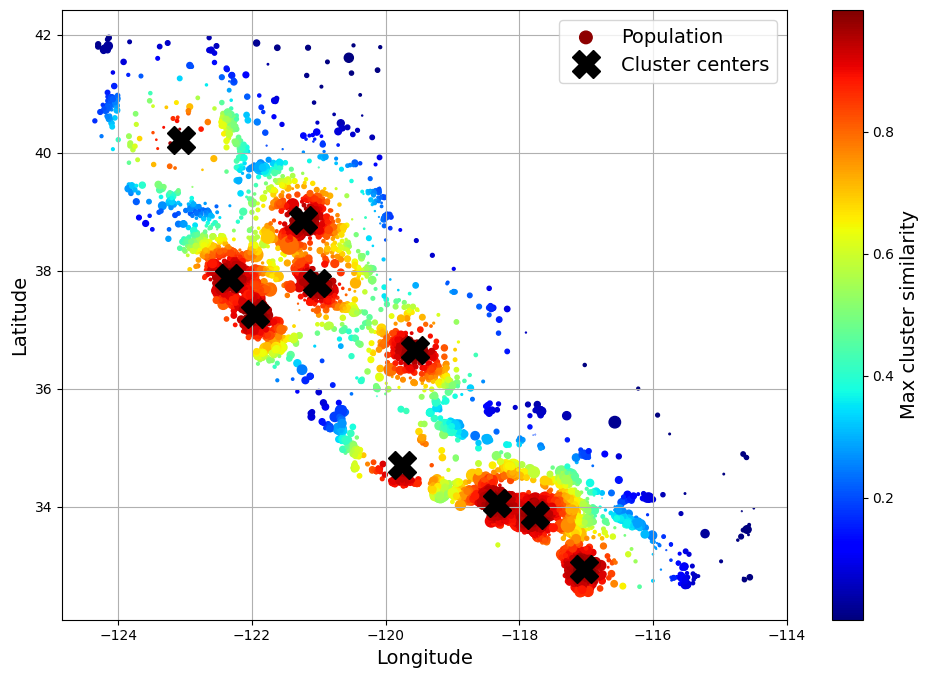

In [90]:
## To show the 10 cluster cneters found by k-means

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

#### Transformation Pipelines

In [91]:
## A small pipeline for numerical attributes, wich will impute then scale the inpute feature

from sklearn.pipeline import Pipeline

num_pipelines = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

In [92]:
## To take transformer as positional arguments and createa a Pipeline using the names of the transformers's classes make_pipeline()

from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)



In [93]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [94]:
## To recover a nice dataframe

df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [95]:
df_housing_num_prepared.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789


In [96]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [97]:
num_pipeline[1]

StandardScaler()

In [98]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [99]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [100]:
## To handle the categorical and columns and the numerical column separately
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [101]:
## To automatically select all the feature of a given type. such numerical or categoriclal
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [102]:
## To apply the ColumnTransformer to the housing data
housing_prepared = preprocessing.fit_transform(housing)

In [103]:
## To get the column name and wrap the data in the nice dataframe
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [104]:
## So, now let create a single pipeline that will perform all the transformations

def column_ration(x):
  return x[:, [0]] / x[:, [1]]


def ration_name(function_transformer, feature_names_in):
  return ["ration"]   # feature name out

def ration_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ration, feature_names_out=ration_name)
  )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil  = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
defult_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ration_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("room_per_house", ration_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ration_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=defult_num_pipeline) # one column remaining: housing_median_age

In [105]:
## to fit the transformer
housing_prepared = preprocessing.fit_transform(housing)

## chek the shape of transformer
housing_prepared.shape

(16512, 24)

In [106]:
## Now let run the ColumnTransformer, it perform all the transformations and output a numpy array with 24 features

preprocessing.get_feature_names_out()

array(['bedrooms__ration', 'room_per_house__ration',
       'people_per_house__ration', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Select and Train a Model

After framed the problem, got the data and exlored it, sample a training set and a test set, and wrote a preprocessing pipeline to automatically clean up and prepare data for machine learning algorithm. Now ready to select and train a machibe learning model


#### Training and Evaluation on the Training Set

In [107]:
## To train a basic lenear regression model

from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ration_name at 0x7a...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ad7862df850>)])),
                ('linearregression', LinearRegression())])

In [108]:
## After get the linear regression model, now compare the first five predictions to the labels

housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([242800., 375900., 127500.,  99400., 324600.])

In [109]:
## Compare against the actual values:

housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [110]:
## computes the error ratios
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


In [111]:
## To measure the regression model's RMSE on the whole training set by mean_squared_error()

from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse

4712541982.022632

In [112]:
## To finding the complex nonlinear relationship in the data with DecissionTreeRegressor()

from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ration_name at 0x7a...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ad7862df850>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [113]:
## After tained the model, let evaluate it on the training set

housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

#### Better Evaluation Using Cross-Validation

In [114]:
## To split the training set into 10 nonoverlapping supset called folds.
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [115]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,66366.983603
std,1976.844743
min,63557.655007
25%,65004.623899
50%,65886.897085
75%,68129.026040
max,69530.301101


In [116]:
#To computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

,0
count,10.000000
mean,69847.923224
std,4078.407329
min,65659.761079
25%,68088.799156
50%,68697.591463
75%,69800.966364
max,80685.254832


In [117]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [118]:
## Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):

forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse

307005705.4478492

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.


### Fine-Tune Your Model

#### Grid Search

fine when exploring relatively few combination


In [119]:
## To search the best combination of hyperparameter value for the RendomForestregressor.

from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

params_grid = [
    {"preprocessing__geo__n_clusters": [5, 8, 10], "random_forest__max_features": [4, 6, 8]},
    {"preprocessing__geo__n_clusters": [10, 15], "random_forest__max_features": [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, params_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ad7862df850>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [120]:
##  get the full list of hyperparameters available for tuning by looking at full_pipeline.get_params().keys()

print(str(full_pipeline.get_params().keys())[:1000]+"")

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__force_int_remainder_cols', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__transform_input', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 

In [121]:

## Get the best combination of parameters

grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [122]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ration_name at 0x7ad786...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ad7861e3750>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [123]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43007,43683,44158,43616
13,15,8,43697,44011,44819,44176
7,10,6,43710,44133,45227,44356
9,10,6,43710,44133,45227,44356
6,10,4,43798,44233,45100,44377


The meaRNSE score for the best model is 43616 is batter than the defult hyperparameter values (47,019)


#### Randomizes Search

When  the hyperparameter search space is large

In [124]:
## To use the RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20),
}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ad787cca310>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ad756b7c8d0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [125]:
# displays the random search results as a table
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41224,42385,42712,42107
8,32,7,41374,42579,43230,42394
0,41,16,42397,42640,43175,42738
5,42,4,41874,43348,43690,42971
2,23,8,42421,43137,43585,43048


**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

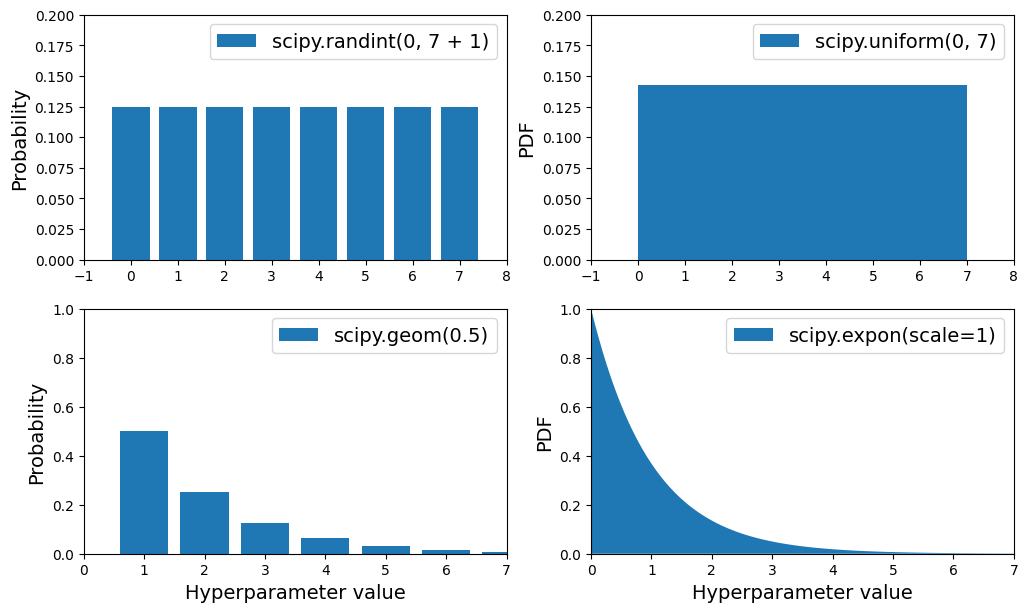

In [126]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()